### This notebook is used to find the slopes of short time scale variations in quasar light curves.

Import necessary files and libraries.

In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import data_parse
from data_parse import *
from center_data import center_data
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
cm = 1/2.54
plt.style.use(['science', 'no-latex'])
plt.rc('font', size=8)
plt.rcParams['font.family'] = 'monospace'
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import matplotlib.colors as mclolors
width = 15.466*cm
height = width/2.55

%matplotlib inline

Choose how the analysis should be implemented, i.e.:
- which reference frame do you want: RF (Reference Frame) = 'qso' (quasar) or 'obs' (observer)
- which fitting method do you want to use: method = 'quadratics' or 'straights'
- how small of timescales are you interested in: minww (minimum window width) = 40 (as used in main study)
- which dataset do you want to use: dataset = 'macho' or 'kepler' or 'cosmograil' or 'sdss'

In [2]:
RF      = 'qso'
method  = 'quadratics'
minww   = 20
dataset = 'macho'

if RF not in ['qso','obs'] :
    print('Undefined reference frame')
if method not in ['quadratics','straights'] :
    print('Undefined finding method')
if dataset not in ['macho','kepler','cosmograil','sdss'] :
    print('Unknown dataset')
    
qlist, quasar = getattr(data_parse, 'parse_data_'+dataset)(RF)
zs = [quasar[qlist[n]]['z'] for n in range(len(qlist))]
flux = [np.vstack((quasar[qn]['time'], quasar[qn]['flux'], quasar[qn]['fluxerr'])).T
       for qn in qlist]

100%|███████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.33it/s]


Clean up the data and prepare it for analysis. If we want to make any cuts (i.e. only high redshift or really well sampled data) then now is the time.

In [3]:
zcutoff = False   ## redshift cut
Ncutoff = True    ## number of datapoints cut
Lcutoff = True    ## observation length cut

if zcutoff :
    mask = [zs[i] <= .2 for i in range(len(zs))]
    flux = [flux[i] for i in range(len(flux)) if mask[i]]
    qlist = [qlist[i] for i in range(len(qlist)) if mask[i]]
    zs = [zs[i] for i in range(len(zs)) if mask[i]]

if Ncutoff :
    mask = [len(flux[i][:,0]) >= 5e2 for i in range(len(flux))]
    flux = [flux[i] for i in range(len(flux)) if mask[i]]
    qlist = [qlist[i] for i in range(len(qlist)) if mask[i]]
    zs = [zs[i] for i in range(len(zs)) if mask[i]]

if Lcutoff :
    mask = [np.ptp(flux[i][:,0]) >= 2e2 for i in range(len(flux))]
    flux = [flux[i] for i in range(len(flux)) if mask[i]]
    qlist = [qlist[i] for i in range(len(qlist)) if mask[i]]
    zs = [zs[i] for i in range(len(zs)) if mask[i]]


flux = [clean_data(flux[n]) for n in range(len(flux))]
m = [-2.5*np.log10(np.mean(flux[n][:,1])) for n in range(len(flux))]
flux = [center_data(flux[n]) for n in range(len(flux))]

We can see the redshift and magnitude distribution of the sample. Depending on the choice of reference frame this will either be absolute or apparent magnitude.

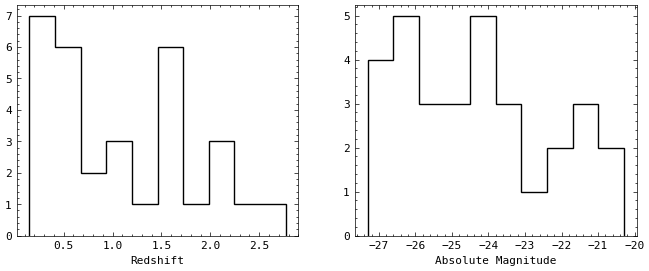

In [4]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(zs, density=False, histtype='step', color='k')
axs[0].set_xlabel('Redshift')
axs[1].hist(m, density=False, histtype='step', color='k')
if RF == 'qso' :
    axs[1].set_xlabel('Absolute Magnitude')
else :
    axs[1].set_xlabel('Observed Magnitude')

We now apply the finding method (either quadratic or straights). Both methods work well with the quadratic slightly outperforming the straights. The below illustration shows the difference of the two methods.
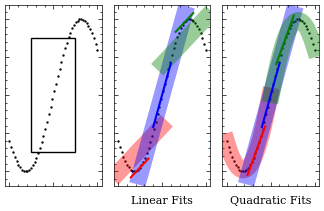
If we are interested in finding the slope of the boxed in linear region on the leftmost figure (without an a priori definition of the region) then there are two ways to do so:

- Linear Method: We can fit data subsections to straight lines and take the slopes of these lines. The average slope will approximate the intended one. But, it is clear that the blue fit does well sense it overlaps the intended region but the red and green regions contain turning points in the data so they underperform. The effect of turning points can be mitigated by weighting each slope value by the corresponding goodness of fit value; this way the blue slope is weighted more than the red and green.
- Quadratic Method: We can fit the subsections with quadratic functions and take the slope value which is half way between the minimum and the maximum of the fitted line. This reduces the effect of the turning points sense they will either be at the minimum or maximum of the fitted line while at the same time not affecting the success of the blue region.

From the illustration the quadratic method seems to outperform the linear method significantly. However, since the turning points are fitted better to a quadratic function, their goodness of fit values will provide less descrimation between the regions. So there is a trade off between the two methods: linear method fits worse but discrimates more while the quadratic method fits better and discriminates less.

Below we perform the fitting methods. Quite a few things are recorded by the methods but only a couple are actually necessary: fit_params which contains the slope values and chi2dof which is the goodness of fit measures. The other parameters (window_width, window_midpoints, best_fit) are for illustrative purposes only; although, window_width can be employed to look at the slope behavior for different timescales. This has not yet been implemented though.

In [5]:
if method == 'quadratics' :
    from find_quadratics import find_quadratic
    if RF == 'qso' :
        window_width, window_midpoints, fit_params, chi2dof, best_fit = zip(*[find_quadratic(flux[n], minww)
                                                                             for n in tqdm(range(len(flux)))])
    else :
        ## in observer frame you must rescale the mininum window so that it is the same for all quasars
        window_width, window_midpoints, fit_params, chi2dof, best_fit = zip(*[find_quadratic(flux[n], minww*(1+zs[n]))
                                                                             for n in tqdm(range(len(flux)))])
elif method == 'straights' :
    ## currently find straights_v3 outperforms *_v1 and *_v2
    from find_straights_v3 import find_straights
    if RF == 'qso' :
        window_width, fit_params, chi2dof, best_fit = zip(*[find_straights(flux[n], minww)
                                                            for n in tqdm(range(len(flux)))])
    else :
        ## in observer frame you must rescale the mininum window so that it is the same for all quasars
        window_width, fit_params, chi2dof, best_fit = zip(*[find_straights(flux[n], minww*(1+zs[n]))
                                                           for n in tqdm(range(len(flux)))])

  0%|          | 0/31 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Some light curves might not meet some of the criteria imposed in the finding method resulting in no measured slope values. This is usually quite rare unless you are dealing with a very large database like the SDSS S82 sample. The MACHO sample for instance has none of these cases. But we do a quick check and clear them out.

In [6]:
if not np.any([type(window_width[n]) is list for n in range(len(window_width))]) :
    mask = [type(window_width[n]) is list for n in range(len(window_width))]
    flux = flux[mask]
    qlist = qlist[mask]
    window_width = window_width[mask]
    if method == 'quadratics' :
        ## only in the quadratics method is window_midpoints defined
        window_midpoints = window_midpoints[mask]
    fit_params = fit_params[mask]
    chi2dof = chi2dof[mask]
    best_fit = best_fit[mask]
    zs = zs[mask]
    m = m[mask]
    
print('Number of quasars in final sample: {}'.format(len(flux)))

Number of quasars in final sample: 31


We will choose the light curve that is sampled the best and use it for demonstration.

In [7]:
index = np.where(np.asarray([len(window_midpoints[n]) for n in range(len(window_midpoints))]) == max([len(window_midpoints[n]) for n in range(len(window_midpoints))]))[0][0]
print('{} reference ID: {}'.format(dataset,qlist[index]))

macho reference ID: 9.4882.332


[None, None]

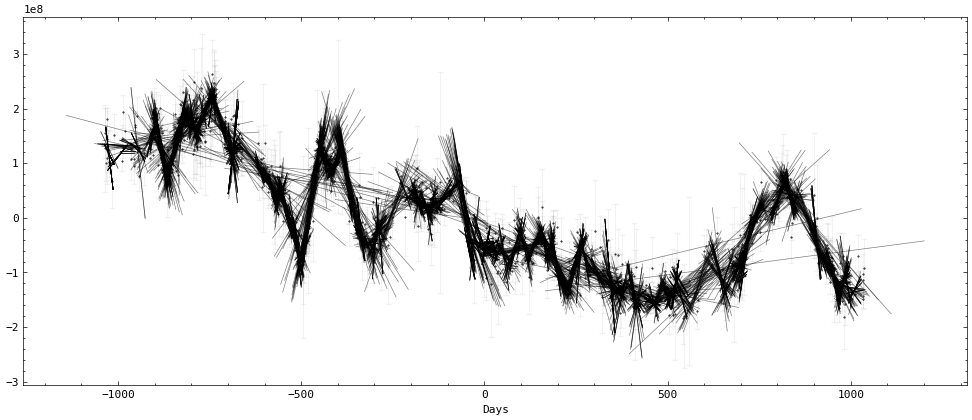

In [8]:
flux_centered = center_data(flux[index])
fig, axs = plt.subplots(1,1, figsize=(2*width,2*height))
axs.scatter(flux_centered[:,0], flux_centered[:,1], c='k', s=0.2)
markers, caps, bars = axs.errorbar(flux_centered[:,0], flux_centered[:,1], yerr=flux_centered[:,2], xerr=None,
                                  ls='none', c='k', capsize=2, elinewidth=0.7, markeredgewidth=1, label=qlist[index]+',  z = '+str(quasar[qlist[index]]['z']))
if method == 'quadratics' :
    [axs.plot(np.linspace(window_midpoints[index][i]-0.5*window_width[index][i],
                         window_midpoints[index][i]+0.5*window_width[index][i], 3),
             [(2*fit_params[index][i,0]*window_midpoints[index][i] + fit_params[index][i,1])
             *(ti-window_midpoints[index][i]) + (fit_params[index][i,0]*window_midpoints[index][i]**2
                                                + fit_params[index][i,1]*window_midpoints[index][i] + fit_params[index][i,2])
             for ti in np.linspace(window_midpoints[index][i]-0.5*window_width[index][i], window_midpoints[index][i]+0.5*window_width[index][i], 3)],
                                  c='k', linewidth=0.5, alpha=0.5)
             for i in range(len(window_midpoints[index]))]
else :
    [axs.plot(best_fit[index][i][:,0], best_fit[index][i][:,1], c='k', linewidth=0.5, alpha=0.5)
        for i in range(len(best_fit[index]))]
axs.set_xlabel('Days')
axs.set_label('Flux')
[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]

Now that we have fitted the light curves we can start looking at the statistical properties of the measured slopes.

In [9]:
from scipy.optimize import curve_fit
from scipy.stats import norm, skewnorm
def skewnormfit(x, a, loc, scale) :
    return skewnorm.pdf(x, a=a, loc=loc, scale=scale)

In [10]:
## define the boundaries for the fitting parameters
## those chosen here should apply for both 'qso' and 'obs' frames
bounds = ((-50,-50,0),(50,50,100))

## for one quasar
fps = fit_params[index]
order = np.argsort(chi2dof[index])[::-1]
weights = 1/chi2dof[index]
if method == 'quadratics' :
    wmpts = window_midpoints[index]
    data = [abs(fps[i,1] + 2*fps[i,0]*wmpts[i]) for i in order]
else :
    data = [abs(fps[i,0]) for i in order]
    
## give a range of slope values to plot against
slope_range = np.linspace(min(np.log10(data))-1, max(np.log10(data))+1, 100)

logsf = 6.093651705567144^(+0.3913041460357629)_(-0.4006707325389396)


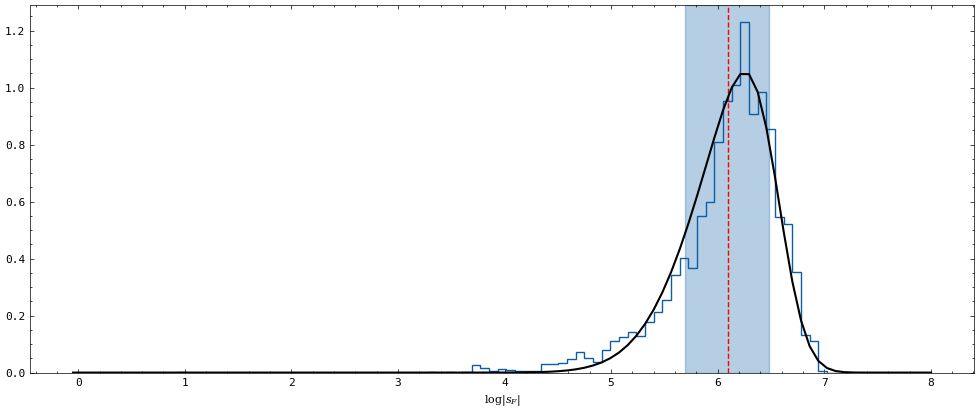

In [11]:
fig, axs = plt.subplots(1,1, figsize=(2*width, 2*height))
h = axs.hist([np.log10(d) for d in data], bins=slope_range, density=True, weights=weights, histtype='step')

## fit the histogram
p = curve_fit(skewnormfit, h[1][:-1], h[0], bounds=bounds)
lower_upper = skewnorm.interval(0.68, p[0][0], loc=p[0][1], scale=p[0][2])
axs.axvspan(lower_upper[0], lower_upper[1], alpha=0.3, color='C0')
fit = skewnorm.pdf(slope_range, a=p[0][0], loc=p[0][1], scale=p[0][2])
mean = skewnorm.mean(a=p[0][0], loc=p[0][1], scale=p[0][2])
mode = slope_range[np.where(fit==np.max(fit))[0]]
axs.axvline(mean, lw=1, c='r', ls='--')
print('logsf = {}^(+{})_(-{})'.format(mean, lower_upper[1]-mean, mean-lower_upper[0]))

axs.plot(slope_range, skewnorm.pdf(slope_range, a=p[0][0], loc=p[0][1], scale=p[0][2]), c='k', lw=1.5)
if RF == 'qso' :
    axs.set_xlabel('$\log|s_F|$')
else :
    axs.set_xlabel('$\log|s_f|$')


Now we just repeat the process for all of the quasars in the dataset.

  0%|          | 0/31 [00:00<?, ?it/s]

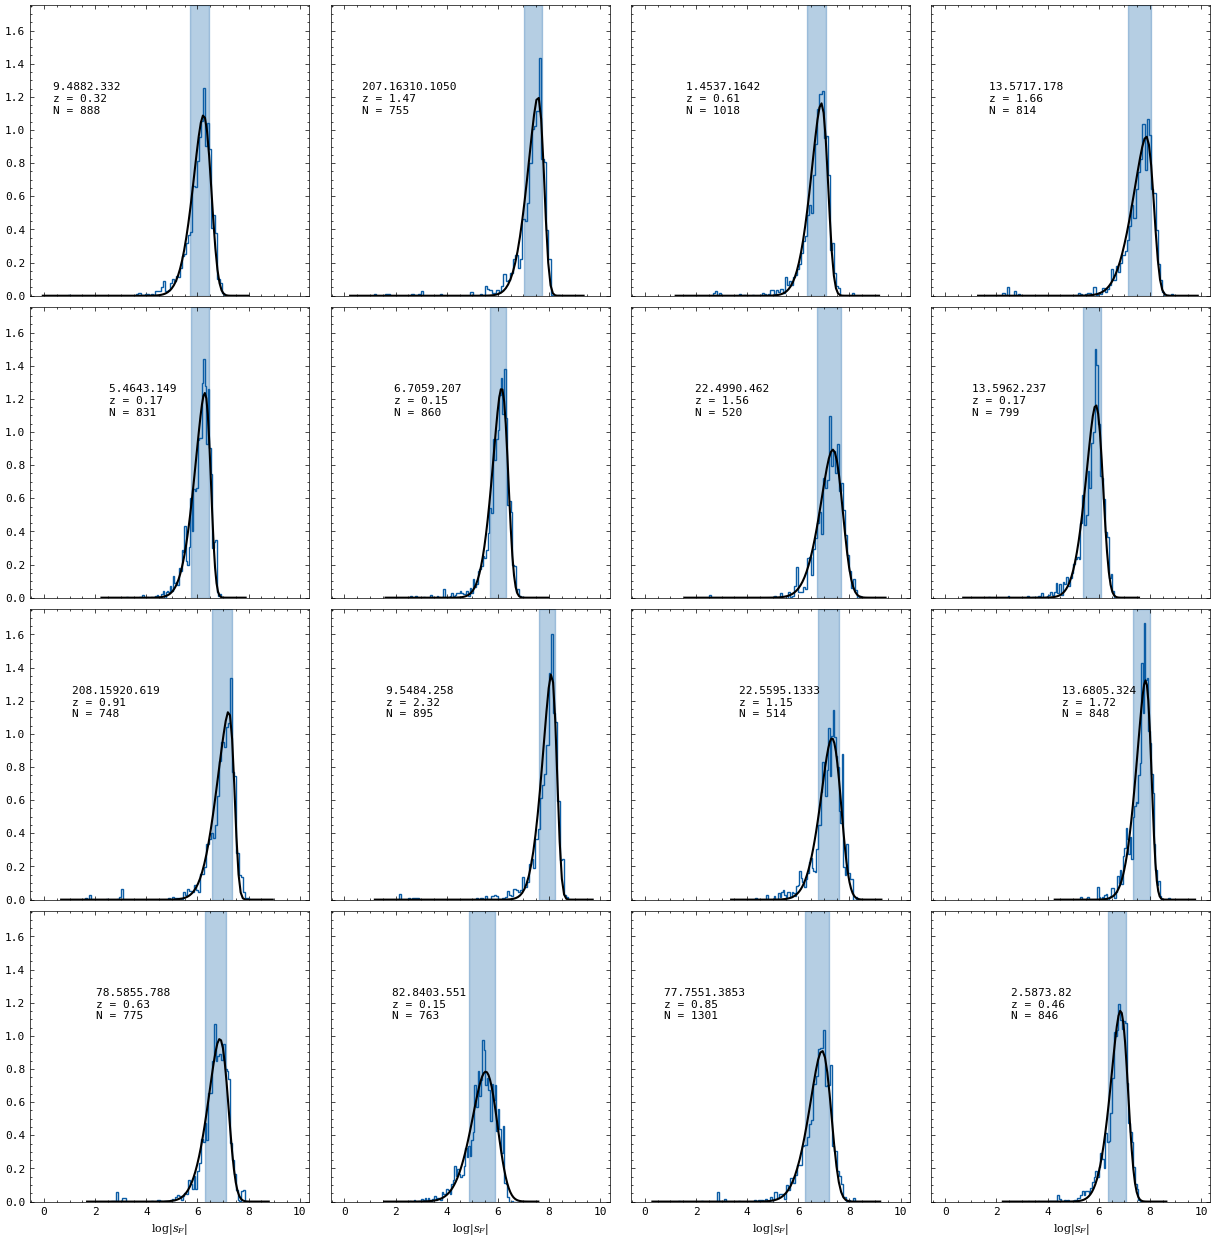

In [12]:
logsf = []
logsf_errs = []
ns = []   ## ns will be used to keep track of which distributions can be fitted properly
fig, axs = plt.subplots(4,4, figsize=(2*width, 2*width), sharex=True, sharey=True)
plt.tight_layout(pad=0.1)
for n in tqdm(range(len(zs))) :
    order = np.argsort(chi2dof[n])[::-1]
    weights = 1/chi2dof[n]
    
    if method == 'quadratics' :
        mask = [(fit_params[n][i,1]+2*fit_params[n][i,0]*window_midpoints[n][i]) >= 0 for i in order]
        data = [abs(fit_params[n][i,1]+2*fit_params[n][i,0]*window_midpoints[n][i]) for i in order if mask[i]]
        weights = [weights[i] for i in range(len(weights)) if mask[i]]
    else :
        data = [abs(fit_params[n][i,0]) for i in order]
        
    slope_range = np.linspace(min(np.log10(data))-1, max(np.log10(data))+1, 100)
    h = np.histogram([np.log10(d) for d in data], bins=(len(slope_range)-1),
                     range=(np.min(slope_range), np.max(slope_range)), density=True, weights=weights)
    
    try :
        p = curve_fit(skewnormfit, h[1][:-1], h[0], bounds=bounds)
        lower_upper = skewnorm.interval(0.68, p[0][0], loc=p[0][1], scale=p[0][2])
        fit = skewnorm.pdf(slope_range, a=p[0][0], loc=p[0][1], scale=p[0][2])
        #sf = slope_range[np.where(fit==np.max(fit))[0]]
        sf = skewnorm.mean(a=p[0][0], loc=p[0][1], scale=p[0][2])
        if RF == 'qso' :
            logsf.append(sf - np.log10(1+zs[n]))
        else :
            logsf.append(sf)
        logsf_errs.append(np.ptp(skewnorm.interval(0.68, p[0][0], loc=p[0][1], scale=p[0][2])))
        ns.append(n)
        
        if n<16 :
            axs[n//4, n-int((n//4)*4)].hist([np.log10(d) for d in data], bins=slope_range,
                                           density=True, weights=weights, histtype='step')
            axs[n//4, n-int((n//4)*4)].plot(slope_range, fit, c='k', lw=1.5)
            axs[n//4, n-int((n//4)*4)].axvspan(lower_upper[0], lower_upper[1], alpha=0.3, color='C0')
            axs[n//4, n-int((n//4)*4)].text(min(slope_range)+0.05*np.ptp(slope_range),1.1,
                                           '{} \nz = {} \nN = {}'.format(qlist[n], quasar[qlist[n]]['z'], len(flux[n][:,0])))
            if n//4==3 :
                if RF == 'qso' :
                    axs[n//4, n-int((n//4)*4)].set_xlabel('$\log|s_F|$')
                else :
                    axs[n//4, n-int((n//4)*4)].set_xlabel('$\log|s_f|$')
    except :
        continue

If the statistics on the slopes is too poor for a quasar then get rid of it (not likely in MACHO dataset but common in SDSS S82).

In [13]:
if len(ns) != len(zs) :
    m = [m[n] for n in ns]
    zs = [zs[n] for n in ns]
    qlist = [qlist[n] for n in ns]

The COSMOGRAIL dataset is comprised of strongly lensed quasars causing multiple light curves of the same quasar (slightly shifted in time from each other). It is not yet clear how one should properly account for this, but for now if you choose to average the light curves together then here is how.

In [14]:
want2average = False
if dataset == 'cosmograil' and want2average :
    unique_qsos = list(dict.fromkeys([qlist[i][:-1] for i in range(len(qlist))]))
    logsf_mean = []
    logsf_errs_mean = []
    m_mean = []
    zs_mean = []
    for i in range(len(unique_qsos)) :
        logsf_mean.append(np.array(np.mean([logsf[j] for j in range(len(logsf)) if qlist[j][:-1]==unique_qsos[i]])))
        logsf_errs_mean.append(np.array(np.mean([logsf_errs[j] for j in range(len(logsf_errs)) if qlist[j][:-1]==unique_qsos[i]])))
        m_mean.append(np.mean([m[j] for j in range(len(m)) if qlist[j][:-1]==unique_qsos[i]]))
        zs_mean.append(np.mean([zs[j] for j in range(len(zs)) if qlist[j][:-1]==unique_qsos[i]]))
    logsf = logsf_mean
    logsf_errs = logsf_errs_mean
    m = m_mean
    zs = zs_mean

Now we want to look at the relation between $s_F$ and $M$ (in the case of RF = 'qso').

In [15]:
## using a simple least squares fit
coeffs, cov = np.polyfit(m, logsf, 1, cov=True)
perrs = np.sqrt(np.diag(np.hstack(cov)))
fit = np.vstack((m, np.polyval(coeffs, m))).T

## using maximum likelihood estimation (MLE)
from scipy.optimize import minimize
def MLE(B,x,y,dy) :
    yPred = B[0]*x + B[1]
    s2 = dy**2 + B[2]**2
    negLL = -np.sum(-(y-yPred)**2/2/s2 - np.log(np.sqrt(2*np.pi*s2)))
    return negLL

results = minimize(MLE, [0,0,0.5], args=(np.array(m), np.hstack(logsf), np.array(logsf_errs)), bounds=((-1,1),(-5,5),(0,1)))

residuals_ls = [logsf[i] - np.polyval(coeffs, m[i]) for i in range(len(logsf))]
residuals_MLE = [logsf[i] - np.polyval([results.x[0],results.x[1]], m[i]) for i in range(len(logsf))]

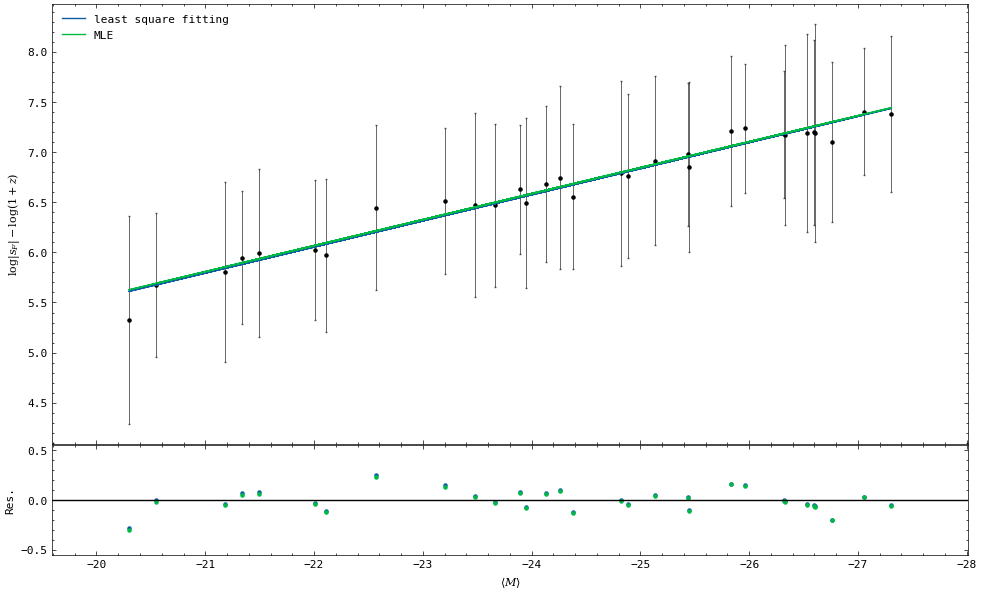

In [16]:
fig, axs = plt.subplots(2,1, figsize=(2*0.8*width, 2*0.8*width/1.66), gridspec_kw={'height_ratios': [4,1]}, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].scatter(m, logsf, s=5, c='k')
markers, caps, bars = axs[0].errorbar(m, np.hstack(logsf),
        yerr=logsf_errs, xerr=None, linestyle='none', c='k', capsize=1, elinewidth=0.7, markeredgewidth=1)
[bar.set_alpha(0.6) for bar in bars]
[cap.set_alpha(0.6) for cap in caps]
axs[0].plot(fit[:,0],fit[:,1], linewidth=1, c='C0', label='least square fitting')
axs[0].plot(fit[:,0], results.x[0]*fit[:,0] + results.x[1], linewidth=1, c='C1', label='MLE')
axs[0].set_xlim(np.min(fit[:,0])-1, np.max(fit[:,0])+1)
if RF == 'qso' :
    axs[0].set_ylabel(r'$\log|s_F| - \log(1+z)$')
else :
    axs[0].set_ylabel(r'$\log|s_f|$')
axs[0].legend()

axs[1].scatter(m, residuals_ls, s=5, c='C0')
axs[1].scatter(m, residuals_MLE, s=5, c='C1')
axs[1].set_ylim(-0.55, 0.55)
axs[1].axhline(y=0, c='k', lw='1')
axs[1].set_xlim(max(m)+0.1*np.ptp(m), min(m)-0.1*np.ptp(m))
axs[1].set_ylabel(r'Res.')
if RF == 'qso' :
    axs[1].set_xlabel(r'$\langle M \rangle$')
else :
    axs[1].set_xlabel(r'$\langle m \rangle$')
plt.tight_layout(pad=0.1)


In the above fitting we see that
$$\log|s_F| - \log(1+z) = \alpha \langle M \rangle + \beta$$
accurately describes the data. The $\log(1+z)$ term comes from the time derivative in the definition of $s_F$ and is well understood. At present the errorbars on $s_F$ are too large to make precise cosmological constraints, but better data and a refinement of the procedures could easily get us there.

But lets look at how well we have done.

Dispersion = 0.10753544774306621


(-0.35, 0.35)

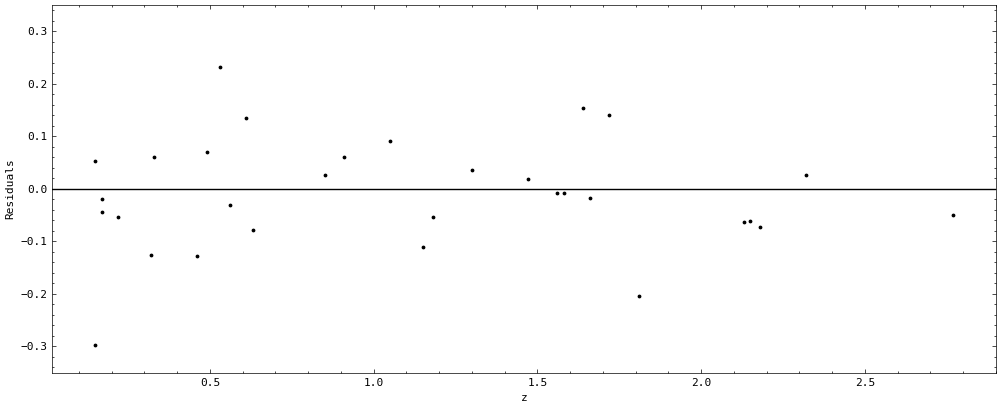

In [17]:
#dispersion = np.sqrt(sum([(fit[i,1] - logsf[i])**2 for i in range(len(logsf))])/(len(logsf)-1))
dispersion = np.sqrt(sum([(results.x[0]*fit[i,0]+results.x[1] - logsf[i])**2 for i in range(len(logsf))])/(len(logsf)-1))
print('Dispersion = {}'.format(dispersion))

fig, axs = plt.subplots(1,1, figsize=(2*width, 2*height))
axs.axhline(y=0, lw=1, c='k')
#axs.scatter(zs, [logsf[i]-coeffs[0]*m[i]-coeffs[1] for i in range(len(logsf))], s=1, c='k')
axs.scatter(zs, [logsf[i]-results.x[0]*m[i]-results.x[1] for i in range(len(logsf))], s=3, c='k')
axs.set_xlabel('z')
axs.set_ylabel('Residuals')
axs.set_ylim(-0.35, 0.35)

In [18]:
print('m = ' + str(coeffs[0]) + '+-' + str(perrs[0][0]))
print('b = ' + str(coeffs[1]) + '+-' + str(perrs[1][1]))

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(m, np.hstack(logsf))
print('slope = ' + str(slope))
print('inter = ' + str(intercept))
print('R2    = ' + str(r_value**2))
print('P     = ' + str(p_value))
print('std_err = ' + str(std_err))

m = -0.2604640831033195+-0.00962982863376403
b = 0.3235680190247724+-0.04747832916254578
slope = -0.26046408310331964
inter = 0.3235680190247656
R2    = 0.9618709288521781
P     = 4.0096000197956263e-22
std_err = 0.009629828633763474


Now let's check out the Hubble diagram. Note that this part will not work properly for RF='qso'. For now this is just to copy the work down so I do not forget about it, but eventually I will add below an analysis of quasars with RF='obs' but with the fitted parameters gained from above.

In [19]:
a = coeffs[0]
b = coeffs[1]
da = perrs[0][0]
db = perrs[1][1]
mu_qso = np.hstack([5*(a*m[i] + b - logsf[i])/(2+5*a) - K(zs[i]) for i in range(len(m))])
dmu_qso = np.hstack([5*(2+5*a)**(-1)*np.sqrt((da*(m[i]-5*(a*m[i]+b-logsf[i])/(2+5*a)))**2 + db**2 + logsf_errs[i]**2) for i in range(len(m))])

/tmp/ipykernel_119257/2247028987.py:2: RuntimeWarning: invalid value encountered in log10
  return 5*(np.log10(k*(np.log10(1+z) + a2*np.log10(1+z)**2 + a3*np.log10(1+z)**3 + a4*np.log10(1+z)**4 + a5*np.log10(1+z)**5))-1) + a0
/tmp/ipykernel_119257/2247028987.py:37: RuntimeWarning: divide by zero encountered in log10
  axs.plot(np.linspace(0,4.2,100), [5*(np.log10(d_lum(z)) - 1) for z in np.linspace(0,4.2,100)],


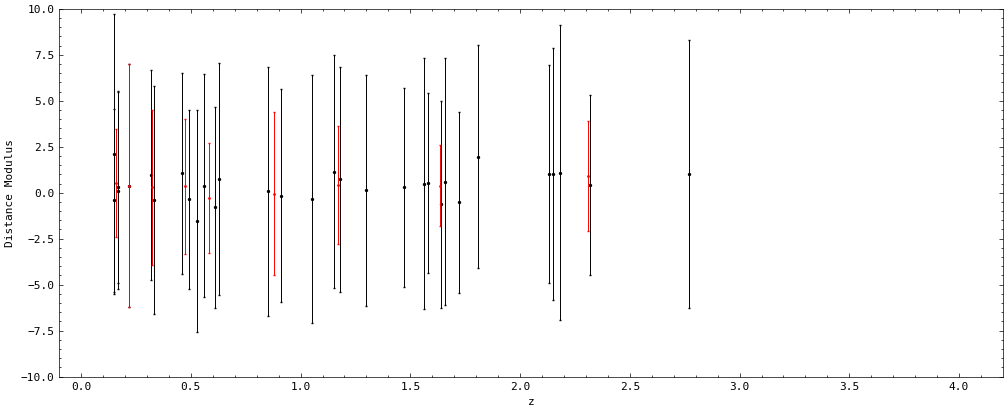

In [20]:
def mu_z_fit(z, k, a2, a3, a4, a5, a0) :
    return 5*(np.log10(k*(np.log10(1+z) + a2*np.log10(1+z)**2 + a3*np.log10(1+z)**3 + a4*np.log10(1+z)**4 + a5*np.log10(1+z)**5))-1) + a0



order_qso = np.argsort(zs)[::-1]
p = curve_fit(mu_z_fit, [zs[n] for n in order_qso], [mu_qso[n] for n in order_qso],
        sigma=[dmu_qso[n] for n in order_qso])
fit = [mu_z_fit(zs[n], p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5]) for n in order_qso]



z_bins = np.geomspace(min(zs)-0.01,max(zs)+0.01,10, endpoint=True)
zs_binned = [np.mean([zs[j] for j in order_qso if (zs[j]>=z_bins[i-1]) & (zs[j]<z_bins[i])])
        for i in range(1,len(z_bins))]
mu_binned = [np.mean([mu_qso[j] for j in order_qso if (zs[j]>=z_bins[i-1]) & (zs[j]<z_bins[i])])
        for i in range(1,len(z_bins))]
dmu_binned = [np.sqrt(sum([dmu_qso[j]**2 for j in range(len(mu_qso))
    if (zs[j]>=z_bins[i-1]) & (zs[j]<z_bins[i])]))/sum(map(lambda x : (x>=z_bins[i-1]) & (x<z_bins[i]), zs))
    for i in range(1,len(z_bins))]

order_qso_binned = np.argsort(zs_binned)[::-1]



fig, axs = plt.subplots(1,1, figsize=(2*width, 2*height))
axs.scatter(zs, mu_qso, s=2, c='k', zorder=32)
markers, caps, bars =axs.errorbar(zs, mu_qso, xerr=None, yerr=dmu_qso,
        linestyle='none', c='k', capsize=1, elinewidth=0.7, markeredgewidth=1, zorder=32)
axs.scatter(zs_binned, mu_binned, s=1, c='r', zorder=33)
try :
    axs.plot([zs_binned[n] for n in order_qso_binned], fit, lw=1, c='r')
except ValueError :
    print('')
axs.errorbar(zs_binned, mu_binned, xerr=None, yerr=dmu_binned,
        ls='none', c='r', capsize=1, elinewidth=0.7, markeredgewidth=1, zorder=33)
axs.plot(np.linspace(0,4.2,100), [5*(np.log10(d_lum(z)) - 1) for z in np.linspace(0,4.2,100)],
        lw=0.8, ls='--', c='k')
axs.set_xlabel('z')
axs.set_ylabel('Distance Modulus')
axs.set_xlim(-0.1, 4.2)
if RF == 'qso' :
    axs.set_ylim(-10,10)
else :
    axs.set_ylim(32.5, 55)
